# Modeling Experiments

(c) ARIH, 2020

This notebook will contain modeling training and inference trials for several modeling types:
- Naive
- Random Forest
- NGBoost
- SVR

In [1]:
# Changing directory because all modules are in root directory
import os

if os.getcwd().split("/")[-1] == "notebooks":
    os.chdir("..")

In [2]:
# Importing modules
import matplotlib
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd

# Other settings
%pylab inline
import seaborn as sns

sns.set_style("whitegrid")
matplotlib.rc("font", family="TakaoPGothic")

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Global constants
RAND_STATE = 1234
CV = 3

# Data variables
DAT_PATH = os.path.join("data", "processed", "per_facility")
FAC_NAME = "GL51.csv"
TARGETS = ["GL51_pow", "GL51_stm"]

# Experiment settings
EXP_NAME = "HP+FE+FS-v0.6"  # HP, HP+FED+FS, HP+FED+FEM+FS
EXP_DESIGN = ["HP", "FE", "FS"]  # Experiment case combination
EXP_PATH = os.path.join("experiments", EXP_NAME)

# Modeling settings
fcast_n_steps = 3
train_range = (-1, "2018-07-01 06:00:00")
test_range = ("2018-07-01 07:00:00", "2019-07-01 07:00:00")

In [4]:
# TODO: Record run times

## Loading data

In [4]:
# Loading data
df = pd.read_csv(os.path.join(DAT_PATH, FAC_NAME), index_col="時刻", parse_dates=["時刻"])
print(df.shape)

(23328, 44)


In [5]:
# Dropping highly correlated variables
correlation_threshold = 0.95
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [
    column for column in upper.columns if any(upper[column] > correlation_threshold)
]

# Drop highly correlated variables
df.drop(to_drop, axis=1, inplace=True)
to_drop

['2U ｵｰﾌﾞﾝ温度_tmp', '3U ｵｰﾌﾞﾝ温度_tmp', '4U ｵｰﾌﾞﾝ温度_tmp', '気温(℃)']

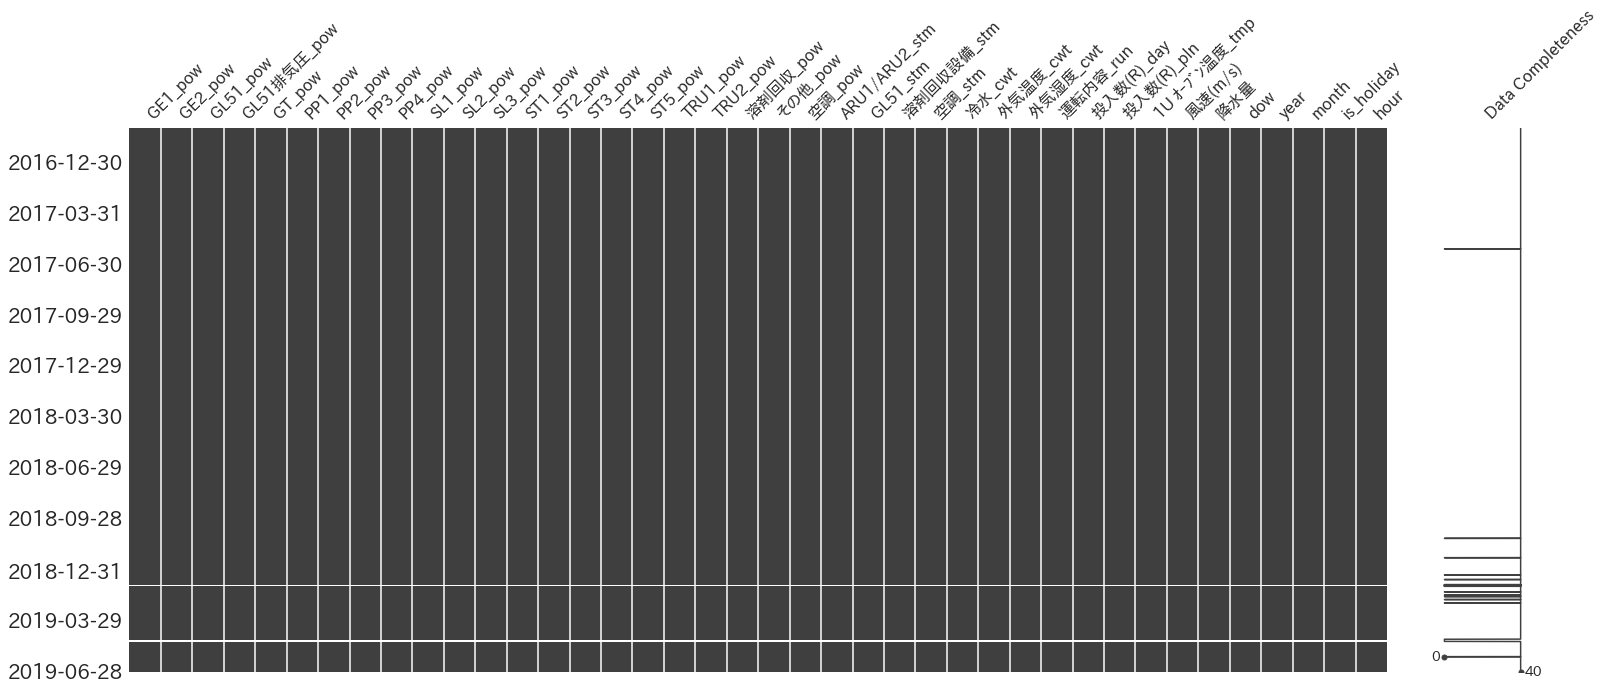

In [6]:
msno.matrix(df, freq="BQ", labels=True)

# Modeling proper

In [32]:
from src.mod_utils import (
    get_naive,
    export_files,
    add_err_steps,
    get_results_metrics,
    ngb_training,
    rf_training,
    svr_training,
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model 0: Naive Predictions

### Preparing data

In [7]:
df_train = df[: train_range[1]]
df_test = df[test_range[0] : test_range[1]]

print((df_train.index.min(), df_train.index.max()))
print((df_test.index.min(), df_test.index.max()))

(Timestamp('2016-11-01 08:00:00'), Timestamp('2018-07-01 06:00:00'))
(Timestamp('2018-07-01 07:00:00'), Timestamp('2019-07-01 07:00:00'))


### Getting predictions

In [8]:
df_res_naive = get_naive(df, TARGETS, fcast_n_steps)

NameError: name 'get_naive' is not defined

In [11]:
df_res_naive_metrics = get_results_metrics(df_res_naive, TARGETS, fcast_n_steps)
df_res_naive_metrics

,mae,r,target
step,,,
t+1,3.064876,0.912508,GL51_pow
t+2,3.888110,0.862943,GL51_pow
t+3,4.157476,0.835742,GL51_pow
t+1,0.013124,0.962245,GL51_stm
t+2,0.020531,0.925850,GL51_stm
t+3,0.026881,0.891604,GL51_stm


In [12]:
# Export files
export_files("naive", df_res_naive, df_res_naive_metrics, EXP_PATH)

## Common Data Preparation for ML

In [9]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

from src.mod_utils import export_files, get_df_lagged, ml_preproc

In [10]:
# Number of hours to lag for target and plan variables
n_forward_target = 3  # GL51_pow t+1,2,3 (objective / target variable)
n_backward_target = 6  # GL51_pow t-1,2,..6 (input / explanatory)

In [11]:
# Copying dataframe to df_ml
df_ml = df.copy()

In [12]:
# Dummy / one-hot encoding
cols_one_hot = ["運転内容_run", "降水量", "is_holiday", "year", "month", "hour", "dow"]
df_ml = pd.get_dummies(df_ml, columns=cols_one_hot, drop_first=True)

In [13]:
if "FE" in EXP_DESIGN:
    df_ml = get_df_lagged(df_ml, "外気湿度_cwt", 0, 3)
    df_ml = get_df_lagged(df_ml, "投入数(Ｒ)_pln", 0, 3)

In [18]:
df_train = df_ml[: train_range[1]]
df_test = df_ml[test_range[0] : test_range[1]]

print((df_train.index.min(), df_train.index.max()))
print((df_test.index.min(), df_test.index.max()))

(Timestamp('2016-11-01 08:00:00'), Timestamp('2018-07-01 06:00:00'))
(Timestamp('2018-07-01 07:00:00'), Timestamp('2019-07-01 07:00:00'))


In [19]:
x_train, y_train, target_cols_shift = ml_preproc(
    df_train, TARGETS, n_backward_target, n_forward_target
)
x_test, y_test, _ = ml_preproc(df_test, TARGETS, n_backward_target, n_forward_target)

(14548, 90)
(8470, 90)


In [21]:
x_train.shape, y_train.shape

((14548, 84), (14548, 6))

In [22]:
# Feature scaling by robust scaler
x_transformer = RobustScaler().fit(x_train)
x_train_sc = pd.DataFrame(
    x_transformer.transform(x_train), columns=x_train.columns
).set_index(x_train.index)
x_test_sc = pd.DataFrame(
    x_transformer.transform(x_test), columns=x_train.columns
).set_index(x_test.index)

In [23]:
# Feature scaling by robust scaler
y_transformer = RobustScaler().fit(y_train)
y_train_sc = pd.DataFrame(
    y_transformer.transform(y_train), columns=y_train.columns
).set_index(y_train.index)
y_test_sc = pd.DataFrame(
    y_transformer.transform(y_test), columns=y_train.columns
).set_index(y_test.index)

In [23]:
# def y_scaler(y, inverse_transform=False):
#     """ Quick hack on GL51 scaling because of known value ranges for 
#     target variables
#     """ 
#     y = y.copy()
    
#     # Range for GL51_pow only
#     POW = (0, 214)
#     STM = (0, 8)
    
#     if inverse_transform:
#         # Transforming to original range
#         for col in y.columns:
#             if "pow" in col:
#                 y[col] = (y[col] * (POW[1] - POW[0])) + POW[0]
#             else:
#                 y[col] = (y[col] * (STM[1] - STM[0])) + STM[0]
    
#     else:
#         # Transforming to scaled range
#         for col in y.columns:
#             if "pow" in col:
#                 y[col] = (y[col] - POW[0]) / (POW[1] - POW[0])
#             else:
#                 y[col] = (y[col] - STM[0]) / (STM[1] - STM[0])
    
    
#     return y

# Target scaling known min-max range
# TODO: Investigate this. Temporary fix for the issues encountered during modeling such as
# loss bias to POW, and constant predictions for STM
# y_train_sc = y_scaler(y_train)
# y_test_sc = y_scaler(y_test)

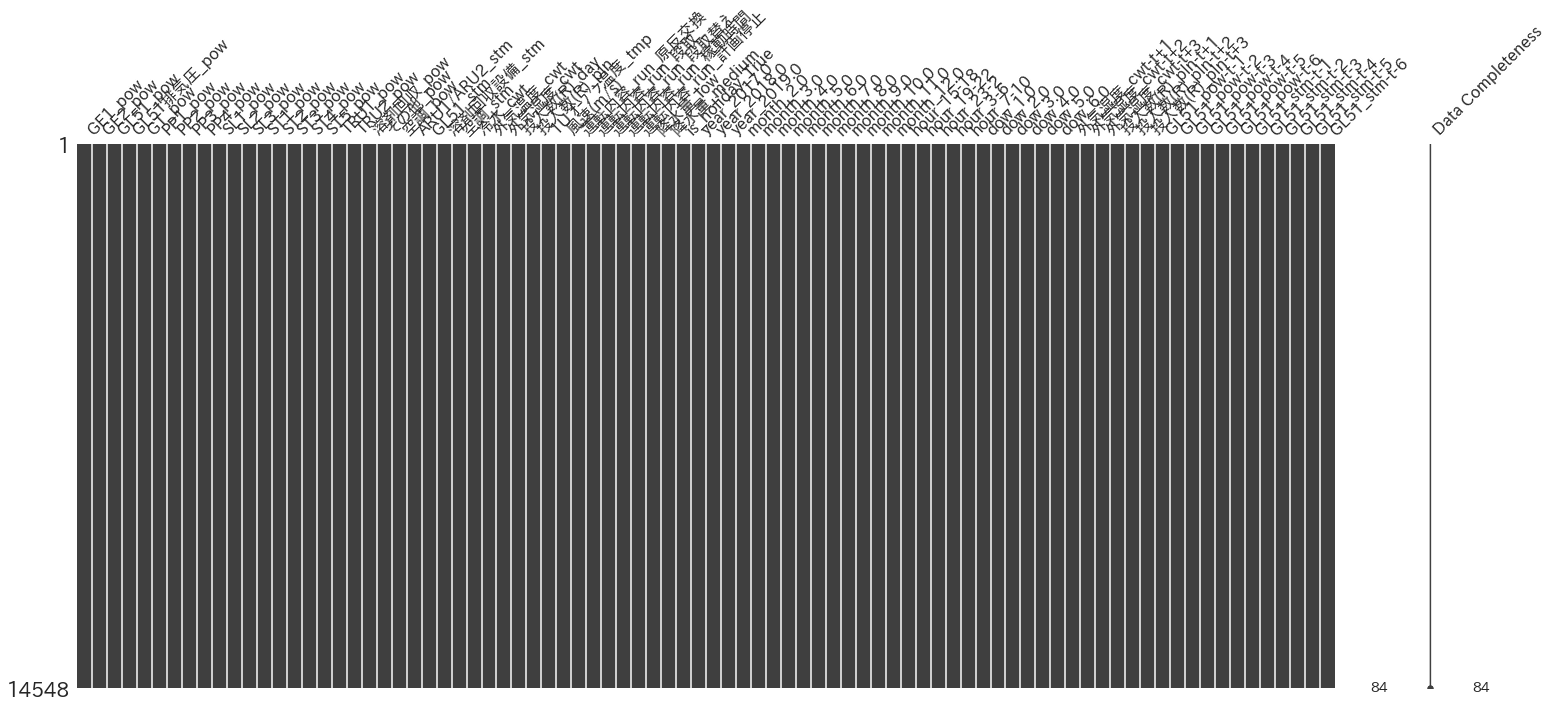

In [24]:
msno.matrix(x_train, labels=True)

In [25]:
# Export ML data
df_exports = {
    "df_train.csv": df_train,
    "df_test.csv": df_test,
    "x_train.csv": x_train,
    "y_train.csv": y_train,
    "x_test.csv": x_test,
    "y_test.csv": y_test,
}

for fname, df in df_exports.items():
    df.to_csv(os.path.join(EXP_PATH, fname))

## Feature selection
Feature selection once (before modeling): Using LassoCV + SelectFromModel

In [25]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import MultiTaskLassoCV

In [26]:
%%time

# Using multitasklassocv because of multi-output format
lasso = MultiTaskLassoCV(cv=CV, random_state=RAND_STATE).fit(x_train_sc, y_train_sc)
coef = np.abs(lasso.coef_)
df_importance = pd.DataFrame(coef, columns=x_train.columns)

CPU times: user 1h 1min 41s, sys: 2h 12min 50s, total: 3h 14min 32s
Wall time: 2min 43s


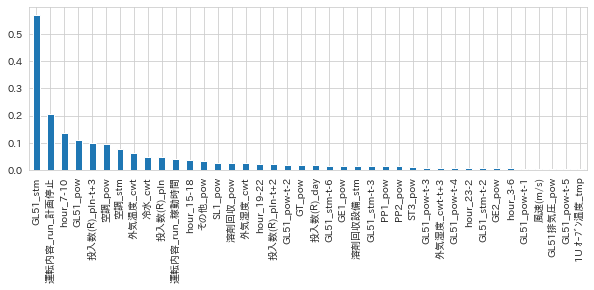

In [27]:
# Showing top 40 important features
n_top_features = 40
plt.rcParams["figure.figsize"] = [10, 3]

# TODO: Investigate n important features
df_importance_top = df_importance.median().sort_values(ascending=False)[:n_top_features]
selected_features = df_importance_top.index
df_importance_top.plot(kind="bar")

In [29]:
# Commenting this out because I sometimes end up with very few features

# # Get features slightly above (+0.01) than the third highest coef
# threshold = np.sort(df_importance.median().values)[-3] + 0.01

# sfm = SelectFromModel(lasso, threshold=threshold).fit(x_train, y_train)
# selected_features = x_train.columns[sfm.get_support()]
# print(
#     "{} features selected by SelectFromModel: {}".format(
#         len(selected_features), selected_features
#     )
# )

In [28]:
selected_features

Index(['GL51_stm', '運転内容_run_計画停止', 'hour_7-10', 'GL51_pow', '投入数(Ｒ)_pln-t+3',
       '空調_pow', '空調_stm', '外気温度_cwt', '冷水_cwt', '投入数(Ｒ)_pln', '運転内容_run_稼動時間',
       'hour_15-18', 'その他_pow', 'SL1_pow', '溶剤回収_pow', '外気湿度_cwt',
       'hour_19-22', '投入数(Ｒ)_pln-t+2', 'GL51_pow-t-2', 'GT_pow', '投入数(Ｒ)_day',
       'GL51_stm-t-6', 'GE1_pow', '溶剤回収設備_stm', 'GL51_stm-t-3', 'PP1_pow',
       'PP2_pow', 'ST3_pow', 'GL51_pow-t-3', '外気湿度_cwt-t+3', 'GL51_pow-t-4',
       'hour_23-2', 'GL51_stm-t-2', 'GE2_pow', 'hour_3-6', 'GL51_pow-t-1',
       '風速(m/s)', 'GL51排気圧_pow', 'GL51_pow-t-5', '1U ｵｰﾌﾞﾝ温度_tmp'],
      dtype='object')

In [29]:
if "FS" in EXP_DESIGN:
    x_train_sc = x_train_sc[selected_features]
    x_test_sc = x_test_sc[selected_features]

In [30]:
x_train_sc

,GL51_stm,運転内容_run_計画停止,hour_7-10,GL51_pow,投入数(Ｒ)_pln-t+3,空調_pow,空調_stm,外気温度_cwt,冷水_cwt,投入数(Ｒ)_pln,...,GL51_pow-t-4,hour_23-2,GL51_stm-t-2,GE2_pow,hour_3-6,GL51_pow-t-1,風速(m/s),GL51排気圧_pow,GL51_pow-t-5,1U ｵｰﾌﾞﾝ温度_tmp
時刻,,,,,,,,,,,,,,,,,,,,,
2016-11-01 14:00:00,-0.090909,0.0,0.0,0.250,0.214286,0.992063,-0.368298,0.266667,0.166667,0.214286,...,0.375,0.0,-0.090909,1.333333,0.0,0.125,0.944444,0.293103,0.125,0.023108
2016-11-01 15:00:00,-0.090909,0.0,0.0,0.250,0.000000,0.825397,-0.370629,0.200000,0.166667,0.214286,...,0.375,0.0,0.000000,0.666667,0.0,0.250,2.722222,0.396552,0.375,-0.006800
2016-11-01 16:00:00,0.090909,0.0,0.0,0.250,0.000000,1.166667,-0.310023,0.266667,0.000000,0.214286,...,-1.250,0.0,-0.090909,1.000000,0.0,0.250,3.111111,0.637931,0.375,-0.038582
2016-11-01 17:00:00,0.181818,0.0,0.0,0.250,0.000000,1.142857,-0.039627,0.200000,0.000000,0.214286,...,0.125,0.0,-0.090909,1.000000,0.0,0.250,1.888889,0.741379,-1.250,0.031365
2016-11-01 18:00:00,0.272727,0.0,0.0,-0.125,0.000000,1.222222,0.046620,0.133333,-0.166667,0.000000,...,0.250,0.0,0.090909,1.000000,0.0,0.250,1.611111,0.724138,0.125,0.023038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-30 23:00:00,-0.636364,0.0,0.0,-1.125,-0.285714,0.309524,-0.207459,1.000000,2.666667,-0.285714,...,0.375,1.0,-0.545455,1.666667,0.0,0.375,0.277778,-2.137931,0.125,-0.255725
2018-07-01 00:00:00,-0.454545,0.0,0.0,-1.250,0.071429,-0.111111,-0.202797,1.000000,2.500000,-0.285714,...,0.375,1.0,-0.545455,1.666667,0.0,-1.125,0.277778,-0.413793,0.375,-0.746940
2018-07-01 01:00:00,-0.545455,0.0,0.0,0.000,0.142857,-0.468254,-0.163170,0.933333,2.666667,-0.285714,...,0.375,1.0,-0.636364,1.666667,0.0,-1.250,0.388889,-0.413793,0.375,-0.507120


## Model 1: Random Forest

### Model training

In [33]:
rf, training_time = rf_training(
    x_train_sc, y_train_sc, cv=CV, rand_state=RAND_STATE, hp_tuning="HP" in EXP_DESIGN
)

Using Hyperparameter tuning.
scores: [-0.23706689 -0.23098964 -0.25071452], mean score: 0.23959035082094263
scores: [-0.24759337 -0.24188785 -0.25688394], mean score: 0.24878838500576653   
scores: [-0.23116648 -0.23704218 -0.25125601], mean score: 0.23982155640154534   
scores: [-0.22937687 -0.23256027 -0.24921947], mean score: 0.23705220383436157   
scores: [-0.23185071 -0.24119484 -0.24950573], mean score: 0.24085042621622074   
scores: [-0.23411909 -0.22940065 -0.24796813], mean score: 0.237162625189312     
scores: [-0.23891862 -0.23122444 -0.24781705], mean score: 0.23932003859328224   
scores: [-0.23027317 -0.23709987 -0.24897673], mean score: 0.23878325320290417   
scores: [-0.23106656 -0.24066808 -0.24932551], mean score: 0.2403533853662676    
scores: [-0.23094858 -0.2292102  -0.24599109], mean score: 0.23538328681806844   
scores: [-0.2259831  -0.22408007 -0.24307597], mean score: 0.23104638160654414    
scores: [-0.23041987 -0.2315469  -0.24985782], mean score: 0.2372748609

### Model testing

In [34]:
# Getting the predictions on x_test
y_pred_sc = rf.predict(x_test_sc)
y_pred = pd.DataFrame(
    y_transformer.inverse_transform(y_pred_sc), columns=target_cols_shift
).set_index(y_test.index)

In [35]:
# Merging true and predicted values
df_res_rf = y_test.merge(
    y_pred, left_index=True, right_index=True, suffixes=("", "_fcast")
)

# Concatenating results and remaining of df
df_res_rf = pd.concat([df_test, df_res_rf], axis=1)

In [36]:
df_res_rf

,GE1_pow,GE2_pow,GL51_pow,GL51排気圧_pow,GT_pow,PP1_pow,PP2_pow,PP3_pow,PP4_pow,SL1_pow,...,GL51_pow-t+3,GL51_stm-t+1,GL51_stm-t+2,GL51_stm-t+3,GL51_pow-t+1_fcast,GL51_pow-t+2_fcast,GL51_pow-t+3_fcast,GL51_stm-t+1_fcast,GL51_stm-t+2_fcast,GL51_stm-t+3_fcast
時刻,,,,,,,,,,,,,,,,,,,,,
2018-07-01 07:00:00,50.0,100.0,35.0,10.0,0.0,35.0,106.0,4.0,4.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-01 08:00:00,60.0,110.0,34.0,10.0,0.0,42.0,87.0,8.0,4.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-01 09:00:00,50.0,100.0,34.0,10.0,0.0,35.0,146.0,4.0,4.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-01 10:00:00,50.0,100.0,34.0,10.0,0.0,41.0,119.0,4.0,4.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-01 11:00:00,50.0,100.0,30.0,10.0,0.0,38.0,146.0,0.0,4.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-01 03:00:00,100.0,40.0,33.0,10.0,0.0,24.0,31.0,0.0,2.0,7.0,...,35.0,0.31,0.3,0.3,32.035799,30.856919,28.824976,0.290301,0.279738,0.263590
2019-07-01 04:00:00,100.0,50.0,29.0,10.0,0.0,25.0,31.0,0.0,1.0,6.0,...,35.0,0.30,0.3,0.3,31.658936,30.228068,28.351175,0.280850,0.270021,0.255927
2019-07-01 05:00:00,100.0,40.0,35.0,10.0,100.0,25.0,35.0,0.0,2.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# Adding error for each fcast step
df_res_rf = add_err_steps(df_res_rf, TARGETS, fcast_n_steps)

# Getting metrics summary
df_res_rf_metrics = get_results_metrics(
    df_res_rf,
    TARGETS,
    fcast_n_steps,
    details={"model": "RF", "time (s)": training_time, "settings": EXP_DESIGN},
)
df_res_rf_metrics

,mae,r,target,model,time (s),settings
step,,,,,,
t+1,2.935056,0.934781,GL51_pow,RF,54.722,"[HP, FE, FS]"
t+2,3.274040,0.909628,GL51_pow,RF,54.722,"[HP, FE, FS]"
t+3,3.568431,0.890358,GL51_pow,RF,54.722,"[HP, FE, FS]"
t+1,0.015560,0.964946,GL51_stm,RF,54.722,"[HP, FE, FS]"
t+2,0.020962,0.940614,GL51_stm,RF,54.722,"[HP, FE, FS]"
t+3,0.025731,0.919028,GL51_stm,RF,54.722,"[HP, FE, FS]"


In [35]:
# Export files
export_files("rf", df_res_rf, df_res_rf_metrics, EXP_PATH, model_obj=rf)

## Model 2: NGBoost

### Model training

In [36]:
# TODO: HP tuning considers equal weight on t+1, t+2, t+3 for pow and stm,
# must update this
ngb, training_time = ngb_training(
    x_train_sc,
    y_train_sc,
    n_iter=5,
    cv=CV,
    rand_state=RAND_STATE,
    hp_tuning="HP" in EXP_DESIGN,
)

Using Hyperparameter tuning.
(4365, 40)
{'learning_rate': 0.0, 'n_estimators': 250}          
scores: [-1.9320118  -1.9626027  -1.95953666], mean score: 1.951383721595203
{'learning_rate': 0.05, 'n_estimators': 350}                                  
scores: [-0.22935665 -0.2349558  -0.23726605], mean score: 0.2338594998123217 
{'learning_rate': 0.025, 'n_estimators': 550}                                  
scores: [-0.22734042 -0.23501866 -0.23562956], mean score: 0.23266288025641535 
{'learning_rate': 0.05, 'n_estimators': 150}                                    
scores: [-0.22787265 -0.23559471 -0.23773467], mean score: 0.23373401054445245  
{'learning_rate': 0.05, 'n_estimators': 150}                                    
scores: [-0.22912259 -0.23531673 -0.23697857], mean score: 0.23380596276750223  
100%|██████████| 5/5 [04:14<00:00, 50.93s/trial, best loss: 0.23266288025641535]
Best hyperparameters searched: {'learning_rate': 0.025, 'n_estimators': 550.0}
{'learning_rate': 0.025, 'n

### Model testing

In [37]:
# Getting the predictions on x_test
y_pred_sc = ngb.predict(x_test_sc)
y_pred = pd.DataFrame(
    y_transformer.inverse_transform(y_pred_sc), columns=target_cols_shift
).set_index(y_test.index)

In [38]:
df_res_ngb = y_test.merge(
    y_pred, left_index=True, right_index=True, suffixes=("", "_fcast")
)
df_res_ngb = pd.concat([df_test, df_res_ngb], axis=1)

In [39]:
# Adding error for each fcast step
df_res_ngb = add_err_steps(df_res_ngb, TARGETS, fcast_n_steps)

# Getting metrics summary
df_res_ngb_metrics = get_results_metrics(
    df_res_ngb,
    TARGETS,
    fcast_n_steps,
    details={"model": "NGB", "time (s)": training_time, "settings": EXP_DESIGN},
)
df_res_ngb_metrics

,mae,r,target,model,time (s),settings
step,,,,,,
t+1,2.705617,0.938118,GL51_pow,NGB,381.193,"[HP, FE, FS]"
t+2,3.148083,0.909540,GL51_pow,NGB,381.193,"[HP, FE, FS]"
t+3,3.428966,0.889325,GL51_pow,NGB,381.193,"[HP, FE, FS]"
t+1,0.015040,0.960088,GL51_stm,NGB,381.193,"[HP, FE, FS]"
t+2,0.020720,0.936382,GL51_stm,NGB,381.193,"[HP, FE, FS]"
t+3,0.025600,0.910751,GL51_stm,NGB,381.193,"[HP, FE, FS]"


In [40]:
# Export files
export_files("ngb", df_res_ngb, df_res_ngb_metrics, EXP_PATH, model_obj=ngb)

## Model 3: SVR

### Model training

In [42]:
# Creating multioutput svr
svr, training_time = svr_training(
    x_train_sc, y_train_sc, RAND_STATE, CV, n_iter=20, hp_tuning="HP" in EXP_DESIGN
)

Using Hyperparameter tuning.
scores: [-0.24424311 -0.23918021 -0.26811435], mean score: 0.2505125548076152
scores: [-0.2422636  -0.24407993 -0.2668338 ], mean score: 0.2510591111360072   
scores: [-0.32438644 -0.31629151 -0.32565135], mean score: 0.32210976922351864  
scores: [-0.38343241 -0.37119017 -0.38053417], mean score: 0.37838558268464134  
scores: [-0.26766936 -0.26292659 -0.28242294], mean score: 0.2710062962488755   
scores: [-0.25200546 -0.24209129 -0.27584791], mean score: 0.2566482226714247   
scores: [-0.25757666 -0.2513379  -0.27436392], mean score: 0.26109282771022807  
scores: [-0.3396445  -0.33226533 -0.34148846], mean score: 0.33779942895882237  
scores: [-0.32906745 -0.33022909 -0.3403174 ], mean score: 0.33320464466379723  
scores: [-0.32627235 -0.31900099 -0.3299075 ], mean score: 0.32506028082017063  
scores: [-0.34822266 -0.34706123 -0.36021062], mean score: 0.35183150101090827   
scores: [-0.24433494 -0.24443124 -0.26793832], mean score: 0.2522348360453459    


### Model testing

In [43]:
# Getting the predictions on x_test
y_pred_sc = svr.predict(x_test_sc)
y_pred = pd.DataFrame(y_transformer.inverse_transform(y_pred_sc), columns=target_cols_shift).set_index(y_test.index)

In [44]:
df_res_svr = y_test.merge(
    y_pred, left_index=True, right_index=True, suffixes=("", "_fcast")
)
df_res_svr = pd.concat([df_test, df_res_svr], axis=1)

In [45]:
# Adding error for each fcast step
df_res_svr = add_err_steps(df_res_svr, TARGETS, fcast_n_steps)

# Getting metrics summary
df_res_svr_metrics = get_results_metrics(
    df_res_svr,
    TARGETS,
    fcast_n_steps,
    details={"model": "SVR", "time (s)": training_time, "settings": EXP_DESIGN},
)
df_res_svr_metrics

,mae,r,target,model,time (s),settings
step,,,,,,
t+1,2.798292,0.933108,GL51_pow,SVR,68.832,"[HP, FE, FS]"
t+2,3.203157,0.906569,GL51_pow,SVR,68.832,"[HP, FE, FS]"
t+3,3.432929,0.881612,GL51_pow,SVR,68.832,"[HP, FE, FS]"
t+1,0.015420,0.961700,GL51_stm,SVR,68.832,"[HP, FE, FS]"
t+2,0.020169,0.940098,GL51_stm,SVR,68.832,"[HP, FE, FS]"
t+3,0.023793,0.915424,GL51_stm,SVR,68.832,"[HP, FE, FS]"


In [46]:
# Export files
export_files("svr", df_res_svr, df_res_svr_metrics, EXP_PATH, model_obj=svr)